In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#70 CSV files (50 coordinates for each video) (35 visible + 35 IR videos)
TRAIN = '/content/gdrive/MyDrive/FYP_Drone/ObjectTracking/train'

#30 CSV files (50 coordinates for each video) (15 visible + 15 IR videos)
TEST = '/content/gdrive/MyDrive/FYP_Drone/ObjectTracking/test'

**Training and Testing**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import os

# Define a function to load CSV files from a directory
def load_csv_files(directory):
    files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(".csv")]
    return files

# Define a function to load and create sequences from a CSV file
def process_csv_file(csv_file, window_size):
    df = pd.read_csv(csv_file)
    X = df['x_center'].values
    Y = df['y_center'].values

    X_seq, x_seq = create_sequences(X, window_size)
    Y_seq, y_seq = create_sequences(Y, window_size)

    return X_seq, x_seq, Y_seq, y_seq

# Define a function to create input-output sequences with a specified window size
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Define the window size (number of historical time steps to consider)
window_size = 15

# Load train and test CSV files
train_files = load_csv_files('/content/gdrive/MyDrive/FYP_Drone/ObjectTracking/train')
test_files = load_csv_files('/content/gdrive/MyDrive/FYP_Drone/ObjectTracking/test')

# Process each train file and aggregate sequences
X_train_seq_list, x_train_seq_list = [], []
Y_train_seq_list, y_train_seq_list = [], []
for train_file in train_files:
    X_train_seq, x_train_seq, Y_train_seq, y_train_seq = process_csv_file(train_file, window_size)
    X_train_seq_list.append(X_train_seq)
    x_train_seq_list.append(x_train_seq)
    Y_train_seq_list.append(Y_train_seq)
    y_train_seq_list.append(y_train_seq)

# Concatenate all sequences
X_train_seq = np.concatenate(X_train_seq_list, axis=0)
x_train_seq = np.concatenate(x_train_seq_list, axis=0)
Y_train_seq = np.concatenate(Y_train_seq_list, axis=0)
y_train_seq = np.concatenate(y_train_seq_list, axis=0)

# Process each test file and aggregate sequences
X_test_seq_list, x_test_seq_list = [], []
Y_test_seq_list, y_test_seq_list = [], []
for test_file in test_files:
    X_test_seq, x_test_seq, Y_test_seq, y_test_seq = process_csv_file(test_file, window_size)
    X_test_seq_list.append(X_test_seq)
    x_test_seq_list.append(x_test_seq)
    Y_test_seq_list.append(Y_test_seq)
    y_test_seq_list.append(y_test_seq)

# Concatenate all sequences
X_test_seq = np.concatenate(X_test_seq_list, axis=0)
x_test_seq = np.concatenate(x_test_seq_list, axis=0)
Y_test_seq = np.concatenate(Y_test_seq_list, axis=0)
y_test_seq = np.concatenate(y_test_seq_list, axis=0)

# Reshape data for LSTM input (samples, time steps, features)
X_train_seq = np.reshape(X_train_seq, (X_train_seq.shape[0], X_train_seq.shape[1], 1))
Y_train_seq = np.reshape(Y_train_seq, (Y_train_seq.shape[0], Y_train_seq.shape[1], 1))
X_test_seq = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1], 1))
Y_test_seq = np.reshape(Y_test_seq, (Y_test_seq.shape[0], Y_test_seq.shape[1], 1))

In [ ]:
import time

# Build LSTM model for X coordinates
model_X = Sequential()
model_X.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(window_size, 1)))
model_X.add(Dropout(0.5))
model_X.add(Dense(1))
model_X.compile(optimizer='adam', loss='mean_squared_error')

# Build LSTM model for Y coordinates
model_Y = Sequential()
model_Y.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(window_size, 1)))
model_Y.add(Dropout(0.5))
model_Y.add(Dense(1))
model_Y.compile(optimizer='adam', loss='mean_squared_error')

# Measure training time for model_X
start_time = time.time()
history_X = model_X.fit(X_train_seq, x_train_seq, epochs=100, batch_size=1, verbose=1, validation_data=(X_test_seq, x_test_seq))
end_time = time.time()
training_time_X = (end_time - start_time) / 3600
print(f"Training time for model_X: {training_time_X:.2f} hours")

# Measure training time for model_Y
start_time = time.time()
history_Y = model_Y.fit(Y_train_seq, y_train_seq, epochs=100, batch_size=1, verbose=1, validation_data=(Y_test_seq, y_test_seq))
end_time = time.time()
training_time_Y = (end_time - start_time) / 3600
print(f"Training time for model_Y: {training_time_Y:.2f} hours")

training_time = training_time_X + training_time_Y
print(f"Training time: {training_time:.2f} hours")

Epoch 1/100
2449/2449 [==============================] - 31s 11ms/step - loss: 0.0113 - val_loss: 0.0047
Epoch 2/100
2449/2449 [==============================] - 27s 11ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 3/100
2449/2449 [==============================] - 29s 12ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 4/100
2449/2449 [==============================] - 28s 12ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 5/100
2449/2449 [==============================] - 26s 11ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 6/100
2449/2449 [==============================] - 28s 11ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 7/100
2449/2449 [==============================] - 27s 11ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/100
2449/2449 [==============================] - 27s 11ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 9/100
2449/2449 [==============================] - 25s 10ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 10/100
2449/2449 [==============================]

In [ ]:
training_time1 = training_time * 60
print(f"Training time: {training_time1:.2f} mins")

Training time: 87.79 mins


In [ ]:
model_X.save('/content/gdrive/MyDrive/FYP_Drone/ObjectTracking/weight/model_X_BiLSTM_32_n15.h5')
model_Y.save('/content/gdrive/MyDrive/FYP_Drone/ObjectTracking/weight/model_Y_BiLSTM_32_n15.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained models
model_X = load_model('/content/gdrive/MyDrive/FYP_Drone/ObjectTracking/weight/model_X_BiLSTM_32_n15.h5')
model_Y = load_model('/content/gdrive/MyDrive/FYP_Drone/ObjectTracking/weight/model_Y_BiLSTM_32_n15.h5')

In [ ]:
def predict_with_sliding_window(model, data, window_size):
    predicted_coordinates = []
    current_sequence = data[:window_size].reshape(1, window_size, 1)

    for i in range(len(data) - window_size):
        next_coordinate = model.predict(current_sequence)[0][0]
        predicted_coordinates.append(next_coordinate)
        current_sequence = np.append(current_sequence[:, 1:, :], [[[data[i + window_size]]]], axis=1)

    return np.array(predicted_coordinates)

# Make predictions for X and Y coordinates using the LSTM model
predicted_X_test = predict_with_sliding_window(model_X, X_test_seq.flatten(), window_size)
predicted_Y_test = predict_with_sliding_window(model_Y, Y_test_seq.flatten(), window_size)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step


In [ ]:
actual_coordinates_X = X_test_seq.flatten()[window_size:]
actual_coordinates_Y = Y_test_seq.flatten()[window_size:]
predicted_coordinates_X = predicted_X_test.ravel()
predicted_coordinates_Y = predicted_Y_test.ravel()

print("Shape of actual_coordinates_X:", actual_coordinates_X.shape)
print("Shape of predicted_coordinates_X:", predicted_X_test.shape)
print("Shape of predicted_coordinates_X:", predicted_coordinates_X.shape)

print("Shape of actual_coordinates_Y:", actual_coordinates_Y.shape)
print("Shape of predicted_coordinates_Y:", predicted_Y_test.shape)
print("Shape of predicted_coordinates_Y:", predicted_coordinates_Y.shape)

Shape of actual_coordinates_X: (15735,)
Shape of predicted_coordinates_X: (15735, 1)
Shape of predicted_coordinates_X: (15735,)
Shape of actual_coordinates_Y: (15735,)
Shape of predicted_coordinates_Y: (15735, 1)
Shape of predicted_coordinates_Y: (15735,)


In [ ]:
from sklearn.metrics import mean_squared_error

# Function to calculate Mean Squared Error (MSE)
def calculate_mse(actual, predicted):
    return mean_squared_error(actual, predicted)

# Function to calculate RMSE
def calculate_rmse(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    return np.sqrt(mse)

# Function to calculate MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Convert predicted coordinates to numpy arrays for calculation
actual_coordinates_X = X_test_seq.flatten()[window_size:]
actual_coordinates_Y = Y_test_seq.flatten()[window_size:]
predicted_coordinates_X = predicted_X_test.ravel()
predicted_coordinates_Y = predicted_Y_test.ravel()

# Calculate MSE
mse_X = calculate_mse(actual_coordinates_X, predicted_coordinates_X)
mse_Y = calculate_mse(actual_coordinates_Y, predicted_coordinates_Y)
mse = (mse_X + mse_Y) / 2
print(f"Mean Squared Error (MSE): {mse:.5f}")

# Calculate RMSE
rmse_X = calculate_rmse(actual_coordinates_X, predicted_coordinates_X)
rmse_Y = calculate_rmse(actual_coordinates_Y, predicted_coordinates_Y)
rmse = (rmse_X + rmse_Y) / 2
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")

# Calculate MAPE
mape_X = calculate_mape(actual_coordinates_X, predicted_coordinates_X)
mape_Y = calculate_mape(actual_coordinates_Y, predicted_coordinates_Y)
mape = (mape_X + mape_Y) / 2
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3%}")

Mean Squared Error (MSE): 0.00280
Root Mean Squared Error (RMSE): 0.05122
Mean Absolute Percentage Error (MAPE): 7.434%


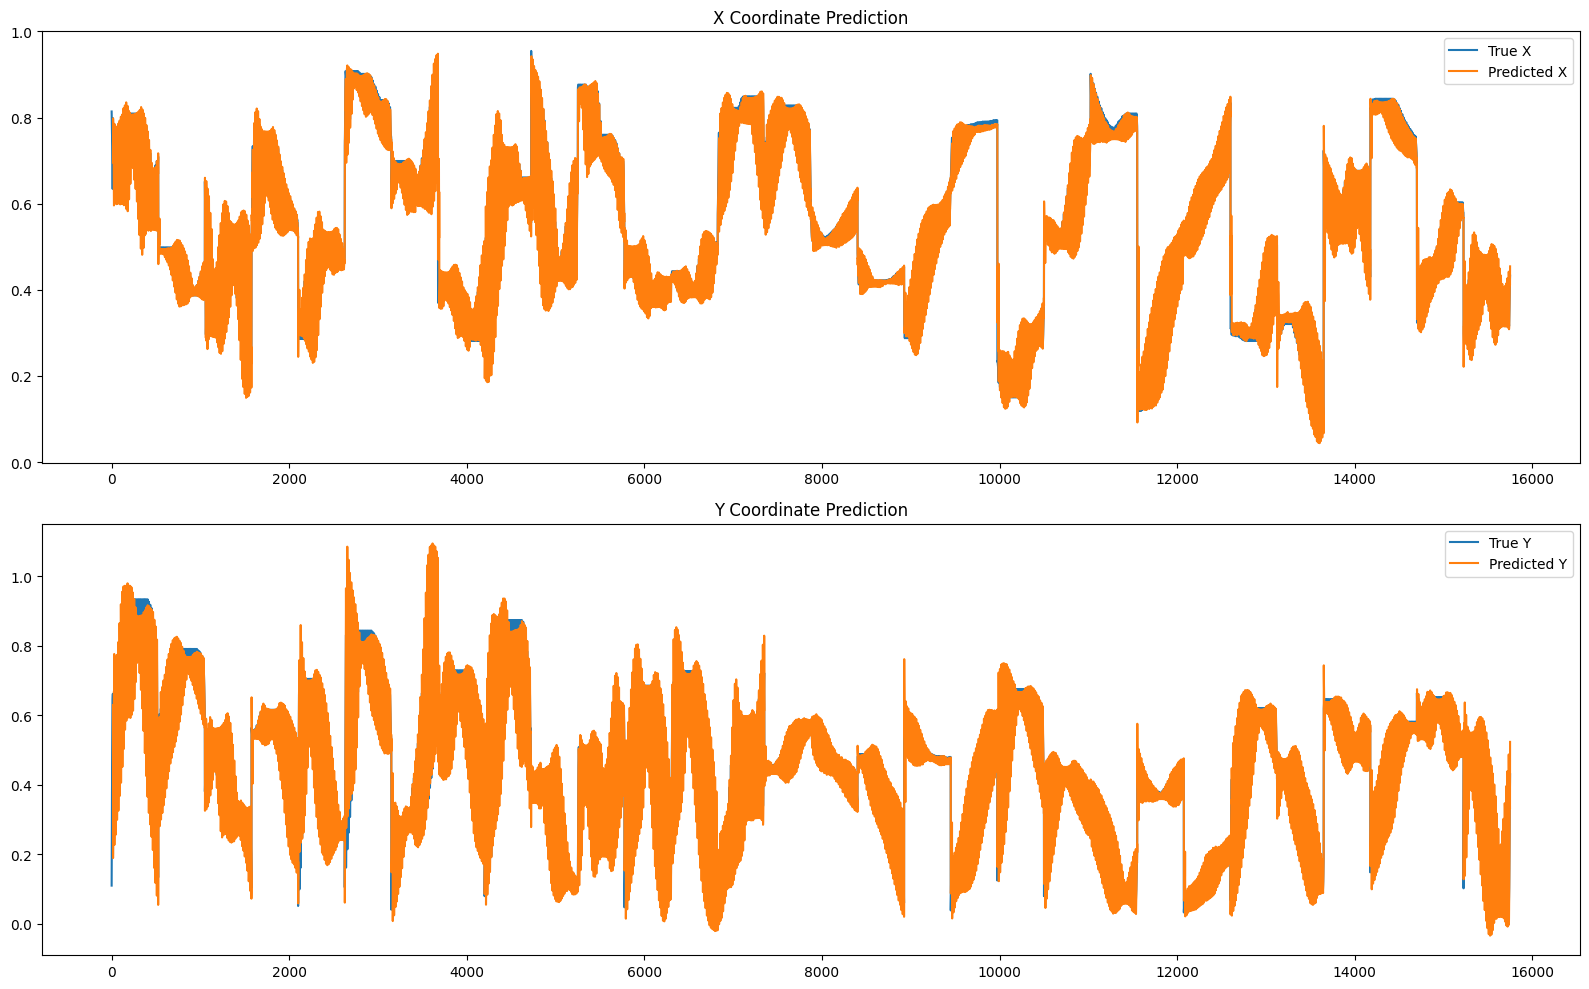

In [ ]:
# Plot the results
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(X_test_seq.flatten(), label='True X')
plt.plot(np.arange(window_size, window_size + len(predicted_X_test)), predicted_X_test, label='Predicted X')
plt.title('X Coordinate Prediction')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Y_test_seq.flatten(), label='True Y')
plt.plot(np.arange(window_size, window_size + len(predicted_Y_test)), predicted_Y_test, label='Predicted Y')
plt.title('Y Coordinate Prediction')
plt.legend()

plt.tight_layout()
#plt.show()

plt.savefig('/content/gdrive/MyDrive/FYP_Drone/ObjectTracking/Plot/BiLSTM(32)(0.5)_n15.png')

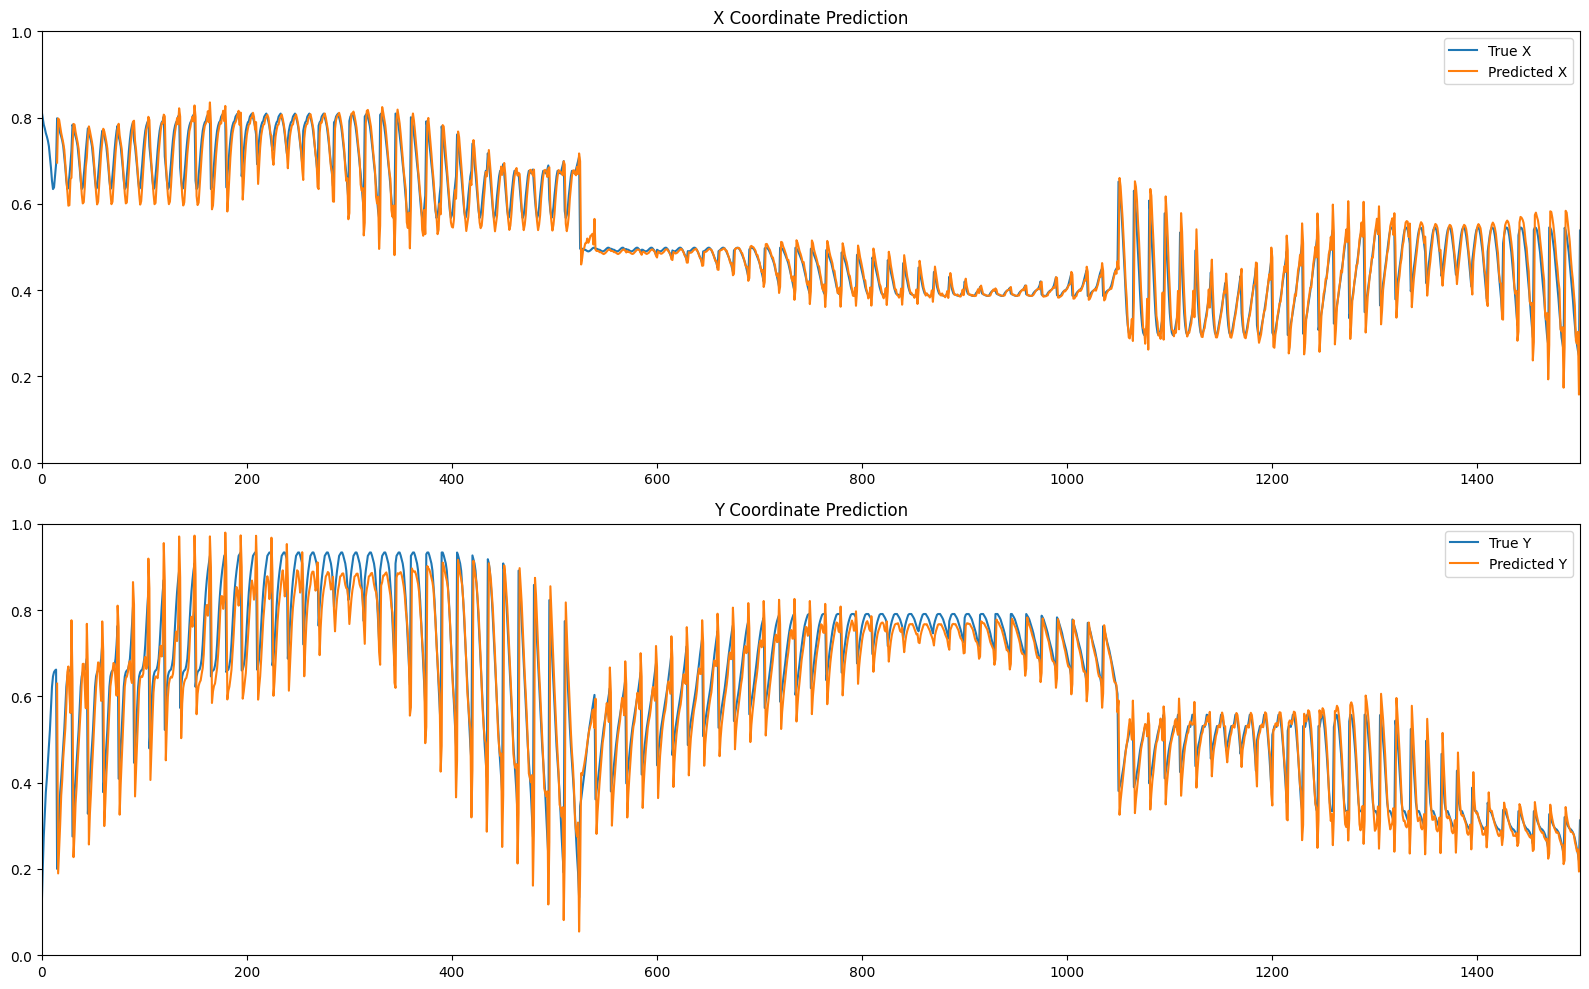

In [ ]:
# Plot the results
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(X_test_seq.flatten(), label='True X')
plt.plot(np.arange(window_size, window_size + len(predicted_X_test)), predicted_X_test, label='Predicted X')
plt.title('X Coordinate Prediction')
plt.legend()
plt.xlim(0, 1500)
plt.ylim(0, 1)

plt.subplot(2, 1, 2)
plt.plot(Y_test_seq.flatten(), label='True Y')
plt.plot(np.arange(window_size, window_size + len(predicted_Y_test)), predicted_Y_test, label='Predicted Y')
plt.title('Y Coordinate Prediction')
plt.legend()
plt.xlim(0, 1500)
plt.ylim(0, 1)
plt.tight_layout()
#plt.show()
plt.savefig('/content/gdrive/MyDrive/FYP_Drone/ObjectTracking/Plot_Detail/BiLSTM(32)(0.5)_n15.png')

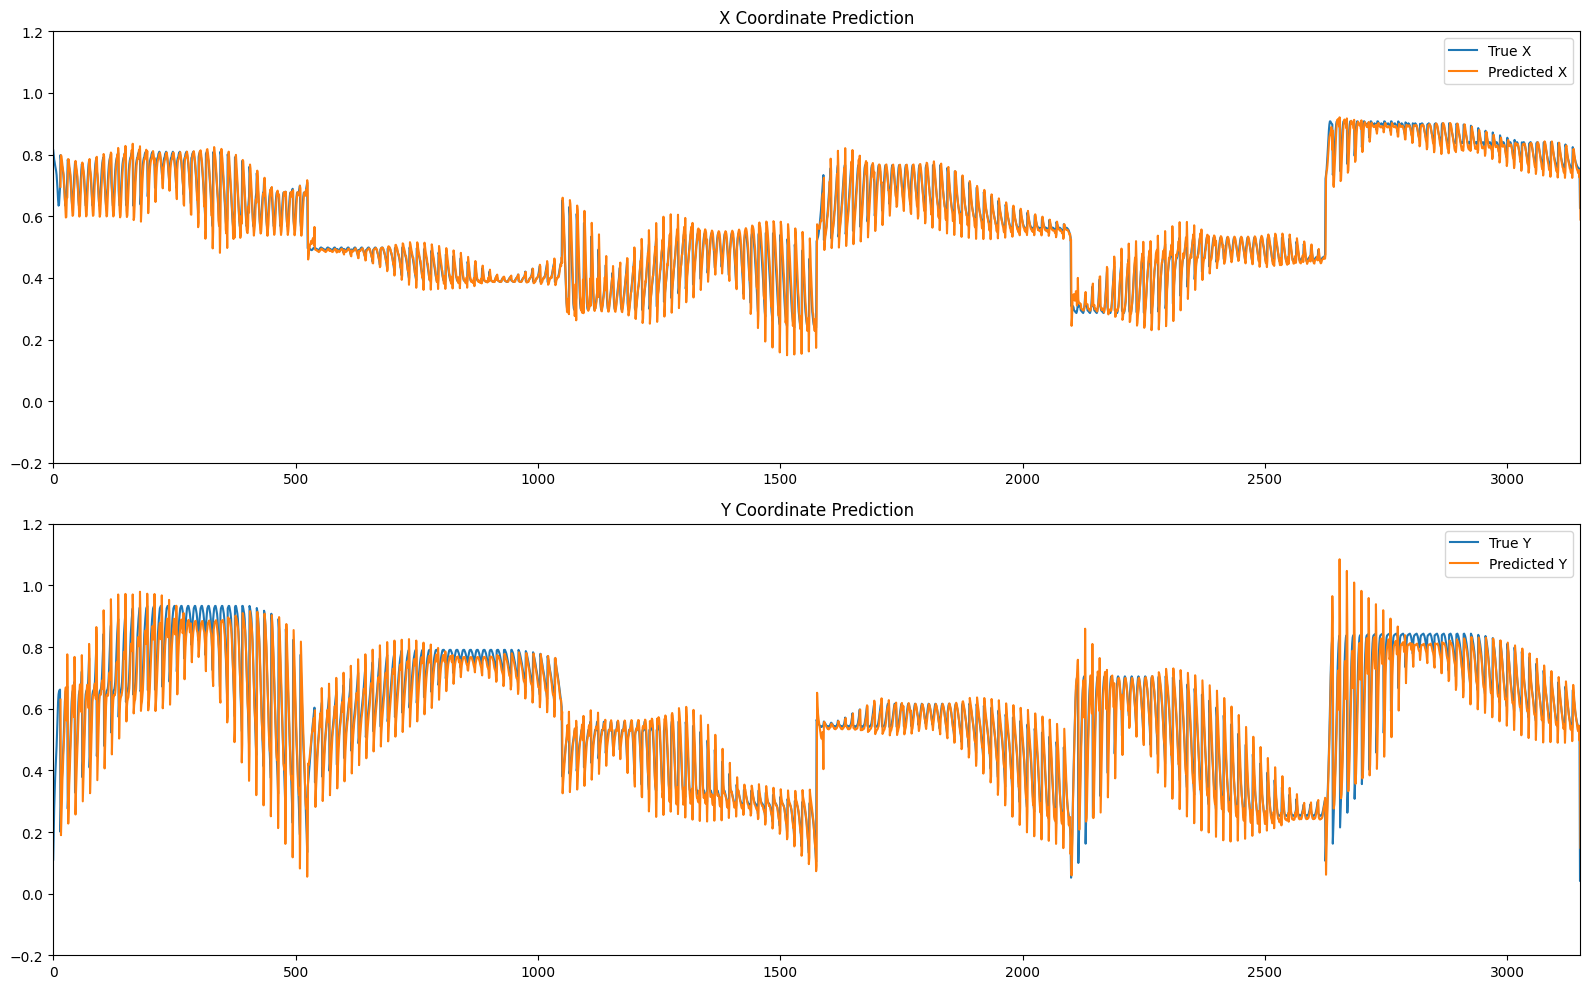

In [15]:
# Plot the results
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(X_test_seq.flatten(), label='True X')
plt.plot(np.arange(window_size, window_size + len(predicted_X_test)), predicted_X_test, label='Predicted X')
plt.title('X Coordinate Prediction')
plt.legend()
plt.xlim(0, len(X_test_seq.flatten()) / 5)  # Limit x-axis to one-fifth of the total samples
plt.ylim(-0.2, 1.2)

plt.subplot(2, 1, 2)
plt.plot(Y_test_seq.flatten(), label='True Y')
plt.plot(np.arange(window_size, window_size + len(predicted_Y_test)), predicted_Y_test, label='Predicted Y')
plt.title('Y Coordinate Prediction')
plt.legend()
plt.xlim(0, len(Y_test_seq.flatten()) / 5)  # Limit x-axis to one-fifth of the total samples
plt.ylim(-0.2, 1.2)
plt.tight_layout()
#plt.show()
plt.savefig('/content/gdrive/MyDrive/FYP_Drone/ObjectTracking/Plot_Detail/BiLSTM(32)(0.5)_n15(2).png')